In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

In [ ]:
(x_train,y_train),(x_test,y_test)=keras.datasets.cifar10.load_data()

n_class=10                      # 부류 수
img_siz=(32,32,3)               # 영상의 크기

patch_siz=4                     # 패치 크기
p2=(img_siz[0]//patch_siz)**2   # 패치 개수
d_model=64                      # 임베딩 벡터 차원
h=8                             # 헤드 개수
N=6                             # 인코더 블록의 개수

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.p_siz=patch_size

    def call(self, img):
        batch_size=tf.shape(img)[0]
        patches=tf.image.extract_patches(images=img,sizes=[1,self.p_siz,self.p_siz,1],strides=[1,self.p_siz,self.p_siz,1],rates=[1,1,1,1],padding="VALID")
        patch_dims=patches.shape[-1]
        patches=tf.reshape(patches,[batch_size,-1,patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self,p2,d_model): # p2: 패치 개수
        super(PatchEncoder,self).__init__()
        self.p2=p2
        self.projection=layers.Dense(units=d_model)
        self.position_embedding=layers.Embedding(input_dim=p2,output_dim=d_model)

    def call(self,patch):
        positions=tf.range(start=0,limit=self.p2,delta=1)
        encoded=self.projection(patch)+self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    input=layers.Input(shape=(img_siz))
    nor=layers.Normalization()(input)

    patches=Patches(patch_siz)(nor)	# 패치 생성
    x=PatchEncoder(p2,d_model)(patches)	# 패치 인코딩

    for _ in range(N):			# 다중 인코더 블록
        x1=layers.LayerNormalization(epsilon=1e-6)(x)		# 층 정규화
        x2=layers.MultiHeadAttention(num_heads=h,key_dim=d_model//h,dropout=0.1)(x1,x1)			# MHA
        x3=layers.Add()([x2,x])		# 지름길 연결
        x4=layers.LayerNormalization(epsilon=1e-6)(x3)	# 층 정규화
        x5=layers.Dense(d_model*2,activation=tf.nn.gelu)(x4)
        x6=layers.Dropout(0.1)(x5)
        x7=layers.Dense(d_model,activation=tf.nn.gelu)(x6)
        x8=layers.Dropout(0.1)(x7)
        x=layers.Add()([x8,x3])		# 지름길 연결

        x=layers.LayerNormalization(epsilon=1e-6)(x)
        x=layers.Flatten()(x)
        x=layers.Dropout(0.5)(x)
        x=layers.Dense(2048,activation=tf.nn.gelu)(x)
        x=layers.Dropout(0.5)(x)
        x=layers.Dense(1024,activation=tf.nn.gelu)(x)
        x=layers.Dropout(0.5)(x)
        output=layers.Dense(n_class,activation='softmax')(x)

        model=keras.Model(inputs=input,outputs=output)
        return model

In [ ]:
model=create_vit_classifier()
model.layers[1].adapt(x_train)

model.compile(optimizer=Adam(),loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
hist=model.fit(x_train,y_train,batch_size=128,epochs=100,validation_data=(x_test,y_test),verbose=1)

res=model.evaluate(x_test,y_test,verbose=0)
print('정확률=',res[1]*100)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


391/391 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.2991 - loss: 2.2637 - val_accuracy: 0.4962 - val_loss: 1.3927
Epoch 2/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4599 - loss: 1.5033 - val_accuracy: 0.5573 - val_loss: 1.2298
Epoch 3/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5239 - loss: 1.3324 - val_accuracy: 0.5944 - val_loss: 1.1454
Epoch 4/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5645 - loss: 1.2096 - val_accuracy: 0.6174 - val_loss: 1.0643
Epoch 5/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5974 - loss: 1.1352 - val_accuracy: 0.6416 - val_loss: 1.0128
Epoch 6/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.6266 - loss: 1.0461 - val_accuracy: 0.6468 - val_loss: 1.0052
Epoch 7/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.6516 - loss: 0.9869 - val_accuracy: 0.6650 - val_loss: 0.9574
Epoch 8/100
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6681 - loss: 0.9322 - val_accurac

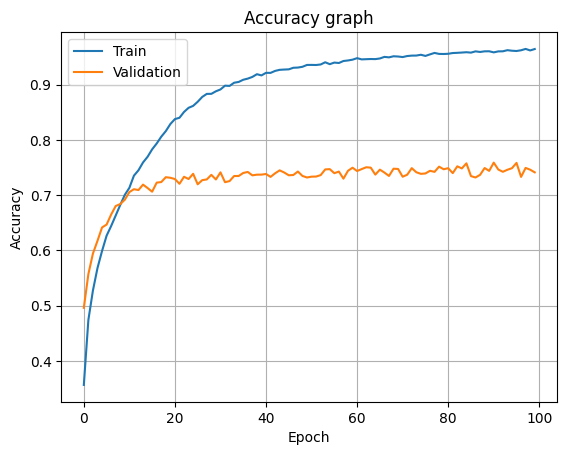

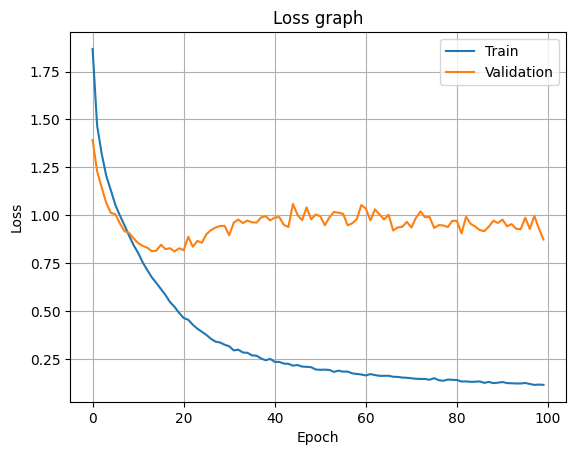

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy graph')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss graph')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'])
plt.grid()
plt.show()